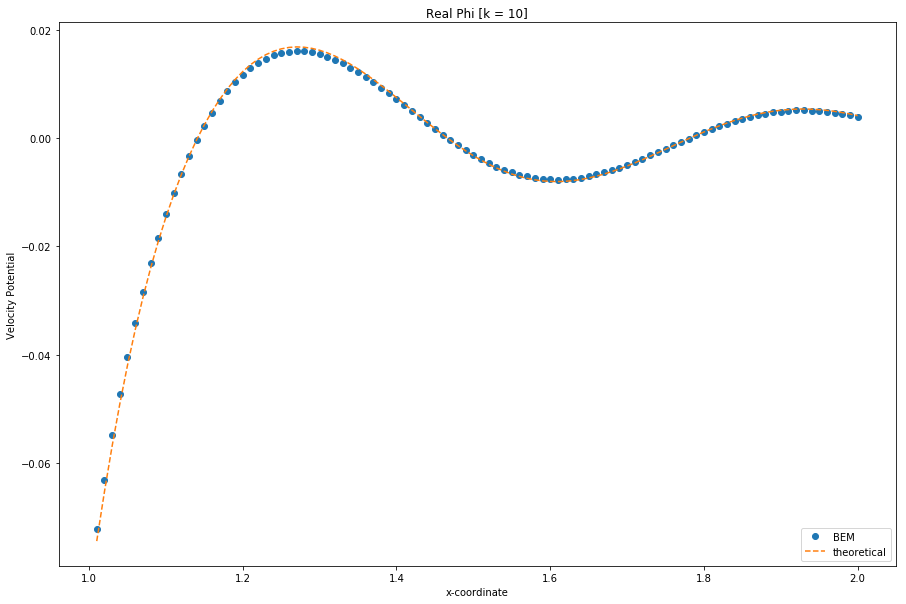

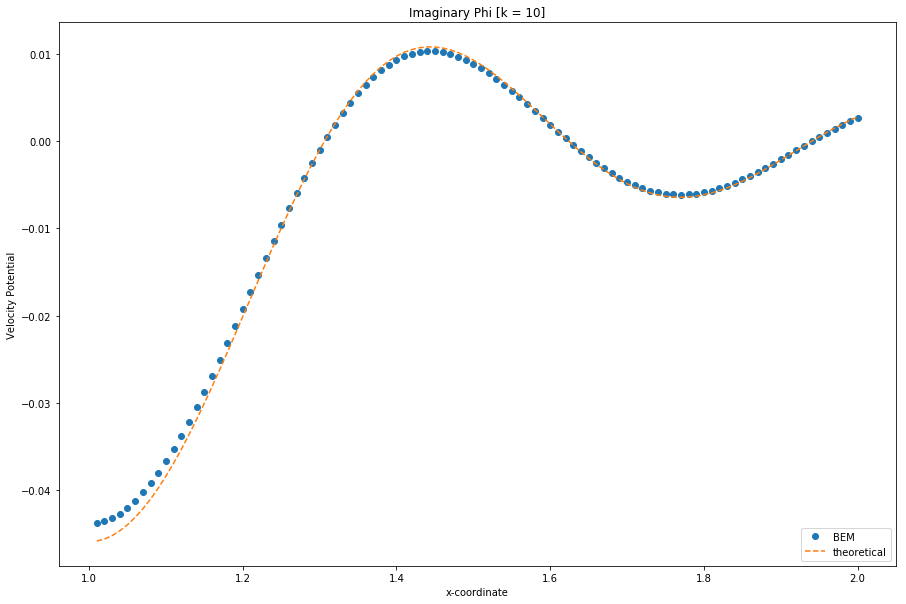

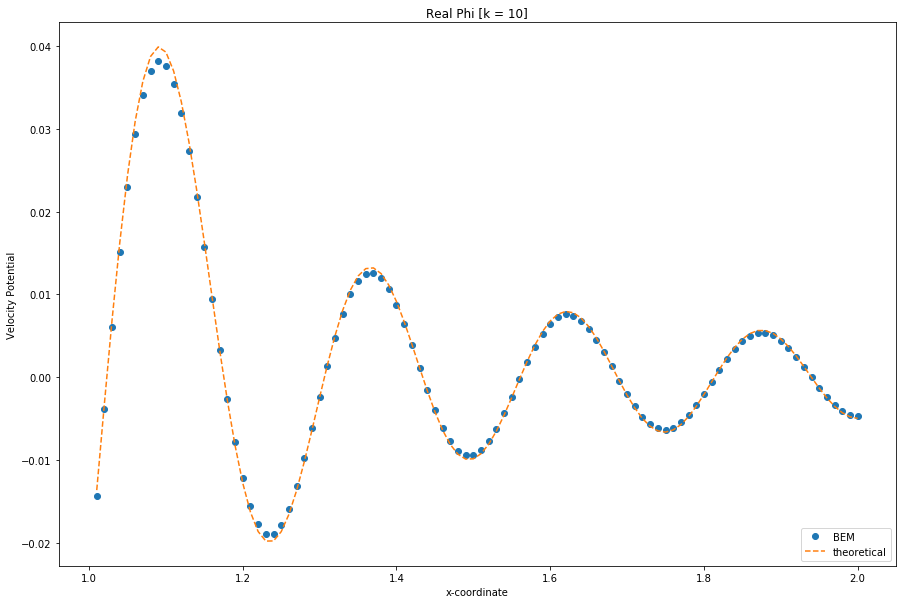

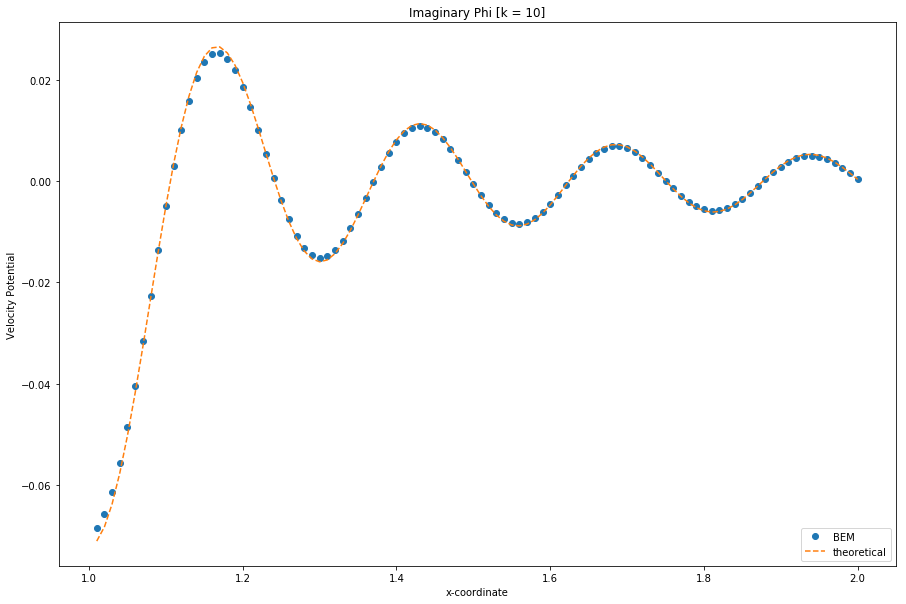

In [1]:
import numpy as np
from ExampleBoundaries import Disk3D
from AcousticProperties import *
from RayleighSolver import *

import gmsh

import matplotlib.pyplot as plt
%matplotlib inline

def disk(r = 0.1, xOffset = 1.0, name = "Disk", maxElementSize = 0.01):
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("disk")
    gmsh.model.geo.addPoint(xOffset,  0.0,  0.0, maxElementSize, 1)
    gmsh.model.geo.addPoint(xOffset,    r,  0.0, maxElementSize, 2)
    gmsh.model.geo.addPoint(xOffset,  0.0,    r, maxElementSize, 3)
    gmsh.model.geo.addPoint(xOffset,   -r,  0.0, maxElementSize, 4)
    gmsh.model.geo.addPoint(xOffset,  0.0,   -r, maxElementSize, 5)

    gmsh.model.geo.addCircleArc(2, 1, 3)
    gmsh.model.geo.addCircleArc(3, 1, 4)
    gmsh.model.geo.addCircleArc(4, 1, 5)
    gmsh.model.geo.addCircleArc(5, 1, 2)

    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.addPhysicalGroup(2, [1], 1)
    gmsh.model.setPhysicalName(2, 1, "Disk")
    gmsh.model.geo.synchronize()

    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.renumberNodes() # force continuous node tags
    gmsh.model.mesh.renumberElements()
    nodeTags, coord, parametricCoord = gmsh.model.mesh.getNodes(2, 1, True)
    # reshape -> (len, 3)
    coord = np.asarray(coord, dtype=np.float32).reshape(len(nodeTags), 3)
    aVertex = np.empty_like(coord)
    minNodeTag = np.min(nodeTags)
    for i, t in enumerate(nodeTags):
        aVertex[t - minNodeTag, :] = coord[i, :]
    elementTypes, elementTags, nodeTags = gmsh.model.mesh.getElements(2, 1)
    assert len(elementTypes) == 1 and elementTypes[0] == 2
    assert len(elementTags) == 1
    assert len(nodeTags) == 1 and len(nodeTags[0] == len(elementTags) * 3)
    aTriangle = np.asarray(nodeTags[0], dtype=np.int32).reshape(len(elementTags[0]), 3)
    aTriangle = aTriangle - np.min(aTriangle) # shift node tags to [0,...,#tags-1] to match node array indices
    gmsh.finalize()

    return aVertex, aTriangle

    
def plotVelocityPotential(title, x, bem, ana):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.title(title)
    BEM, = plt.plot(x, bem, 'o',  label = 'BEM')
    ANA, = plt.plot(x, ana, '--', label = 'theoretical')
    plt.xlabel('x-coordinate')
    plt.ylabel('Velocity Potential')
    plt.legend(handles=[BEM, ANA], loc = 'lower right')
    plt.show()

def phiAnalytic(k, density, c, V, r, x):
    y = np.subtract(x, 1.0)
    const = -1j * V / k
    variable = np.exp(np.multiply(1j * k, y)) - np.exp(1j * k * np.sqrt(np.square(r) + np.square(y)))
    return const * variable

def solve(k, V, vertices, triangles, samples):
    solver = RayleighSolver3D(vertices, triangles)
    boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
    boundaryCondition.alpha.fill(0.0)
    boundaryCondition.beta.fill(1.0)
    boundaryCondition.f.fill(V)

    solution = solver.solveBoundary(k, boundaryCondition)
    return solver.solveSamples(solution, samples)

exteriorPoints = np.zeros((100, 3), dtype=np.float32)
exteriorPoints[:,0] = np.linspace(1.01, 2.0, num=100)


# Test Problem 1

k = 10.0 # Wavenumber
frequency = wavenumberToFrequency(k)
V = 1.0 # piston velocity
c = 344.0
density = 1.205

aVertex, aTriangle = Disk3D()
numericalPhi = solve(k, V, aVertex, aTriangle, exteriorPoints)

x = exteriorPoints[:, 0]
analyticPhi = phiAnalytic(k, density, c, V, 0.1, x)

plotVelocityPotential('Real Phi [k = 10]', x, numericalPhi.real, analyticPhi.real)
plotVelocityPotential('Imaginary Phi [k = 10]', x, numericalPhi.imag, analyticPhi.imag)


# Test Problem 2

k = 25.0 # Wavenumber
frequency = wavenumberToFrequency(k)

numericalPhi = solve(k, V, aVertex, aTriangle, exteriorPoints)

x = exteriorPoints[:, 0]
analyticPhi = phiAnalytic(k, density, c, V, 0.1, x)

plotVelocityPotential('Real Phi [k = 10]', x, numericalPhi.real, analyticPhi.real)
plotVelocityPotential('Imaginary Phi [k = 10]', x, numericalPhi.imag, analyticPhi.imag)
